# Modelling of motor learning as collective motion in parameter space (minimal CMPS model)


__Author__: Tomas Tomka

__Date__:   November 24, 2025

__Objective__: Modelling of context-dependent vocal learning of song syllable features in songbirds. 

__Corresponding paper__: Tomas Tomka. Lifelong motor learning as collective motion in a space of gestures. ScienceOpen Preprints. 2025. https://doi.org/10.14293/PR2199.002384.v1 

### Collective motion in parameter space (CMPS) model:

Let $x_{1,t}, x_{2,t}$ be developmental trajectories of a motor feature of a given gesture in two different context. After a given rendition of the $i$-th context at time $t$, we use the following updating rules:

$x_{i,t+1} = x_{i,t} + a (g_i - x_{i,t})$,

$x_{j,t+1} = x_{i,t} + c_{ji}H(x_{i,t+1},x_{j,t})(x_{i,t+1}-x_{j,t}) , \forall j \neq i $

with the following parameters:

$g_i$ : intrinsic goal for the i-th context

$a$ : drift-rate towards $g_i$

$c_{ji}$ : coupling constant, modulating the attraction of $x_{j,t}$ towards $x_{j,t}$

$H$ is a negative Hill function that defines the distance-dependency of mutual attraction with 
* Hill coefficient $n$ and 
* Hill constant $d_{50}$.

For simplicity, we assume: 
* The individual practices each day a fixed sequence $s=\{1,2,1,2,...\}$ of rendititions in alternating contexts.
* There is only one coupling constant $c = c_{12} = c_{21}$.

## Auxillary functions and settings

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import tol_colors as tc
import pickle as pkl
from copy import deepcopy
%reload_ext autoreload
%autoreload 2
%matplotlib inline

w = 18*0.3937   # page width
pt = 8          # font size
plt.rcParams.update({'legend.fontsize':pt, 
                     'axes.labelsize' : pt, 
                     'axes.linewidth' : 1,
                     'lines.linewidth': 3, 
                     'text.usetex': True, 
                     'ytick.labelsize': pt, 
                     'xtick.labelsize': pt,
                     'savefig.dpi': 300, 
                     'savefig.format':'png',
                     'figure.figsize': (0.3*w, 0.23*w)})

labels = {'t': r'Time [renditions]', 
          'x': r'Motor learning',
          'dg': r'Goal incongruency $|g_1-g_2|$', 
          'dg2': r'Goal incongruency $||g_1-g_2||$', 
          'att': r'H', 
          'c': r'c',
          'dx': r'Distance $||x_{1}-x_{2}||$',
          'eps': r'"Strain" $\log \frac{|x_{1}^*-x_{2}^*|}{|g_1-g_2|}$',
          'E': r'Effort [renditions]',
          'R': r'Robustness',
          'f1': r'Motor feature 1',
          'f2': r'Motor feature 2',
          'ico/co': r'Incongruency degree $\frac{|x_{1}^2-g_{1}^2|}{|x_{1}^1-g_{1}^1|}$'}

colors = {'x1': '#DDCC77',
          'x2': '#44AA99',
          'g': 'lightgrey',
          'H': 'black',
          'ego': '#CC6677',
          'coop': '#A9D18E',
          'spl': '#88CCEE',
          'transfer': 'c',
         }

root_path = 'C:/Users/Startklar/Dropbox/CollectiveMotionPaper'
os.chdir(root_path)
rng = np.random.default_rng(12345)

In [2]:
# mutual local attraction modelled with Hill function variant
def Hill(x1, x2, n, d50):
    return 1 / (1 + (np.linalg.norm(x1 - x2)/d50)**n)

# simulate system of N agents in D dimensional motor space
#     instanteneous vectors are of form:
#     x =[[x11, ..., x1D], ..., [xN1,...,xND]]
def simulate(seq, x0, g, a, C, n, d50, wn, rng):
    ttot = len(seq)
    xt = x0
    N = x0.shape[0]
    
    if len(x0.shape)<2: 
        # 1D motor space
        X = np.empty((ttot, N))
    else: 
        # multi-dimensional motor space
        X  = np.empty((ttot, N, x0.shape[1]))
        
    for t in range(ttot):
        i = int(seq[t])
        X[t,:] = xt
        if np.linalg.norm(g[t] - xt[i])>1e-10: # prevent infinitely small numbers
            X[t, i] = xt[i] + a*(g[t] - xt[i]) + wn*rng.standard_normal(size=xt[i].shape)  
        for j in range(N):
            if j!=i and np.linalg.norm(X[t, i] - xt[j])>1e-10: # prevent infinitely small numbers
                H = Hill(X[t, i], xt[j], n, d50)
                X[t, j] = xt[j] + H*C[j, i]*(X[t, i] - xt[j])
        xt = X[t, :]
    return X

## Modelling local mutual attraction

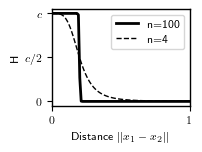

In [3]:
xx = np.linspace(0, 1, 100)
yy = np.zeros(100)
for i in range(100):
    yy[i] = Hill(0, xx[i], 100, 0.2)

plt.figure()
plt.plot(xx, yy, color=colors['H'], label='n=100', lw=2)
plt.xlabel(labels['dx'])
plt.ylabel(labels['att'])
plt.xlim([0, 1])
plt.ylim([-0.05, 1.05])
plt.yticks([0, 0.5, 1], labels=[r'$0$', r'$c/2$', r'$c$'])
plt.xticks([0, 1])

for i in range(100):
    yy[i] = Hill(0, xx[i], 4, 0.2)
plt.plot(xx, yy, color=colors['H'], lw=1, ls='--', label='n=4')
plt.legend()
plt.tight_layout()
plt.savefig('figs/fig3a_Hill')

## The state-space of collective learning
We model a two-agent system (context 1 and 2) with a total of 1000 renditions in an alternating sequence. We expose the system to switched goals after 200 renditions. Before the simulated trial, we equilibrate the system for 200 renditions, starting from initial conditions $x_t=[0,0]$. For illustration (non-identity of agent 1 and 2 in case of goal congruency), we add white noise. 

We first model __congruent learning__ where $g_1=g_2$.

Then __tensioned learning__ where $g_1\neq g_2$ and $H \neq 0$ at steady state. 

And finally __independent learning__ where $g_1\neq g_2$ and $H = 0$ at steady state.

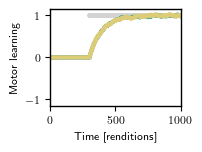

In [4]:
# model parameters
x0 = np.array([0, 0])  # initial condition
gk = np.array([1, 1])  # goals after switch
a = 0.02               # drift-rate towards goals
c = 0.05               # coupling constant
n = 100                # Hill coefficient
d50 = 1                # Hill constant
wn = 0.005             # white noise parameter
tsim = 1000            # number of renditions of context 1 and 2 
tswitch = 300          # time of switch within tsim 
tpre = 200             # time before trial starts (for equilibration)
ttot = tsim + tpre

# plot parameters
xl = [0, 1000]
yl = [-1.15, 1.15]

# sequence of context renditions
seq = np.zeros(ttot, dtype=int)
seq[1::2] = 1

# sequence of goals
g = np.zeros(ttot, dtype=int)
g[tpre+tswitch::2] = gk[0]
g[tpre+tswitch+1::2] = gk[1]

# symmetrical coupling
C = np.array([[0, c], [c, 0]])

# simulation
X = simulate(seq, x0, g, a, C, n, d50, wn, rng)
X = X[tpre:]

# plotting
plt.figure()
plt.plot(X[:,1], color=colors['x2'])
plt.plot(X[:,0], color=colors['x1'])
plt.xlim(xl)
plt.ylim(yl)
plt.yticks([-1,0,1])
plt.xlabel(labels['t'])
plt.ylabel(labels['x'])
plt.scatter(range(tsim), g[tpre:], color=colors['g'], s=5)
plt.tight_layout()
plt.savefig('figs/fig3b_congruent')

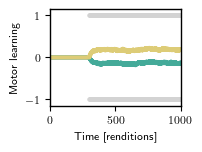

In [5]:
gk = [1, -1]
g = np.zeros(ttot, dtype=int)
g[tpre+tswitch::2] = gk[0]
g[tpre+tswitch+1::2] = gk[1] 

X = simulate(seq, x0, g, a, C, n, d50, wn, rng)
X = X[tpre:]

plt.figure()
plt.plot(X[:,1],color=colors['x2'])
plt.plot(X[:,0],color=colors['x1'])
plt.xlim(xl)
plt.ylim(yl)
plt.yticks([-1,0,1])
plt.xlabel(labels['t'])
plt.ylabel(labels['x'])
plt.scatter(range(tsim), g[tpre:], color=colors['g'], s=5)
plt.tight_layout()
plt.savefig('figs/fig3c_tensioned')

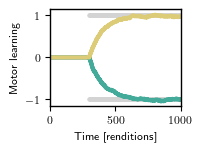

In [6]:
d50 = 0.005
X = simulate(seq, x0, g, a, C, n, d50, wn, rng)
X = X[tpre:]

plt.figure()
plt.plot(X[:,1], color=colors['x2'])
plt.plot(X[:,0], color=colors['x1'])
plt.xlim(xl)
plt.ylim(yl)
plt.yticks([-1, 0, 1])
plt.xlabel(labels['t'])
plt.ylabel(labels['x'])
plt.scatter(range(tsim), g[tpre:], color=colors['g'], s=5)
plt.tight_layout()
plt.savefig('figs/fig3d_independent')

Now we want to screen the __state space of vocal learning__ for different degrees of goal incongruency and different coupling constants.

In [7]:
d50 = 0.2
wn = 0
ndd = 100
ncc = 100
n = 2
doplot = False

out = np.empty((ndd, ncc))
dd = np.linspace(0, 1, ndd)
cc = np.linspace(0, 0.05, ncc)

for i,d in enumerate(dd):
    for j,c in enumerate(cc):
        x0 = np.array([0.5*d, 0.5*d])
        C = np.array([[0, c], [c, 0]])
        g = np.zeros(ttot) + 0.5*d
        g[tpre+tswitch::2] = 0
        g[tpre+tswitch+1::2] = d
        X = simulate(seq, x0, g, a, C, n, d50, wn, rng)
        out[i,j] = abs(X[-1, 0] - X[-1, 1])/d
        if doplot:
            X = X[tpre:]
            plt.figure(figsize=(0.33*w, 0.26*w))
            plt.plot(X)
            plt.scatter(range(tsim), g[tpre:], color=colors['g'], s=30)
            plt.tight_layout()

C:\Users\Startklar\AppData\Local\Temp\ipykernel_18300\3040919362.py:20: RuntimeWarning: invalid value encountered in scalar divide
  out[i,j] = abs(X[-1, 0] - X[-1, 1])/d


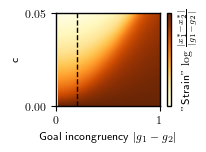

In [8]:
plt.figure()
extent = np.min(dd), np.max(dd), np.min(cc), np.max(cc)
plt.imshow(np.log(out).T, extent=extent, aspect='auto', origin='lower', cmap='YlOrBr')
cbar = plt.colorbar()
cbar.set_label(labels['eps'])
cbar.set_ticks([])
plt.axvline(0.2, color='k', linestyle='--', lw=1)
plt.xlabel(labels['dg'])
plt.ylabel(labels['c'])
plt.xticks([0, 1])
plt.yticks([0, 0.05])
plt.tight_layout()
plt.savefig('figs/fig3e_statespace')

## Robustness and efficiency of collective learners
We examine __efficiency and robustness__ in the state space of two agents in __2D motor space__.

#### Optimal splits
We start by showing with an example that there is an __optimal timepoint to induce a split__: when generalization switches from being beneficial (transfer learning) to being detrimental (inference).

In [9]:
def simulate_optimal(seq, x0, g, a, C, n, d50, wn, rng, tpre):
    
    ttot = len(seq)
    xt = x0
    N = x0.shape[0]

    if len(x0.shape)<2: # 1D motor space
        X = np.empty((ttot, N))
    else: # multi-dimensional motor space
        X  = np.empty((ttot, N, x0.shape[1]))
    
    first_split = np.nan
    
    for t in range(ttot):
        i = int(seq[t])
        X[t,:] = xt
        if np.linalg.norm(g[t] - xt[i])>1e-10: # prevent infinitely small numbers
            X[t, i] = xt[i] + a*(g[t] - xt[i]) + wn*rng.standard_normal(size=xt[i].shape)
        for j in range(N):
            if j!=i and np.linalg.norm(X[t, i] - xt[j])>1e-10: # prevent infinitely small numbers
                H = Hill(X[t, i], xt[j], n, d50)
                x_j_new = xt[j] + H*C[j, i]*(X[t, i] - xt[j])
        
                # stay coupled if benefitial
                if t<=tpre+1 or np.linalg.norm(x_j_new-g[t-1])<np.linalg.norm(xt[j]-g[t-1]):
                    X[t,j] = x_j_new + wn*rng.standard_normal() 
                else:
                    X[t,j] = xt[j]
                    C[j,i] = 0
                    C[i,j] = 0
                    if np.isnan(first_split).any():
                        first_split = x_j_new
                
        xt = X[t]
    return X, first_split

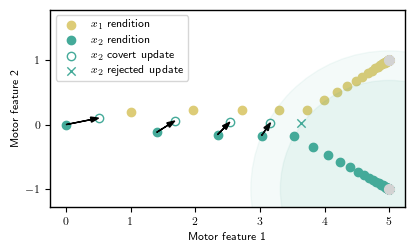

In [10]:
# 2D model parameters 
x0 = np.array([[0, 0],[0,0]])   # initial condition
gk = np.array([[5, 1],[5,-1]])  # goals after switch
a = 0.02*10                     # drift-rate towards goals
c = 0.05*10                     # coupling constant
n = 100                         # Hill coefficient
d50 = 50                      # Hill constant
wn = 0.00                      # white noise parameter
tsim = 1000                     # number of renditions of context 1 and 2 
tswitch = 1                   # time of switch within tsim 
tpre = 200                      # renditions before trial starts (for equilibration)
ttot = tsim + tpre

# sequence of context renditions
seq = np.zeros(ttot, dtype=int)
seq[1::2] = 1

# sequence of goals
g = np.zeros((ttot, 2), dtype=int)
g[tpre+tswitch::2] = gk[0]
g[tpre+tswitch+1::2] = gk[1]

# symmetrical coupling
C = np.array([[0, c], [c, 0.]])

# simulation
X, first_split = simulate_optimal(seq, x0, g, a, C, n, d50, wn, rng, tpre)
X = X[tpre:]

# plotting
plt.figure(figsize=(0.6*w, 0.37*w))
plt.scatter(X[1::2,1,0], X[1::2,1,1], color=colors['x1'], label='$x_1$ rendition')
plt.scatter(X[::2,0,0], X[::2,0,1], color=colors['x2'], label='$x_2$ rendition')
plt.scatter(X[1:8:2,0,0], X[1:8:2,0,1], color='white',edgecolors=colors['x2'], label='$x_2$ covert update')
for i in range(4):
    plt.arrow(X[i*2,0,0], X[i*2,0,1], X[1+i*2,0,0]-X[i*2,0,0], X[1+i*2,0,1]-X[i*2,0,1],
              shape='full', lw=1, length_includes_head=True, head_width=0.08, color=colors['H'])
circ1 = plt.Circle((5, -1), np.linalg.norm(X[8,0,:]-gk[1]), color=colors['x2'], alpha=0.07)
circ2 = plt.Circle((5, -1), np.linalg.norm(X[6,0,:]-gk[1]), color=colors['x2'], alpha=0.06)
plt.scatter(first_split[0],first_split[1],marker='x', color=colors['x2'], lw=1, label='$x_2$ rejected update')
plt.gca().add_artist(circ1)
plt.gca().add_artist(circ2)
plt.legend()
plt.yticks([-1, 0, 1])
plt.xlabel(labels['f1'])
plt.ylabel(labels['f2'])
plt.scatter(gk[:,0], gk[:,1], color=colors['g'], s=50)
plt.axis('equal')
plt.ylim([-1,1.5])
plt.tight_layout()
plt.savefig('figs/fig5a_transfer')

#### Effort as a function of coupling and goal incongruency
We now compute the effort $E$ in total number of renditions needed to reach the targets upto an accuracy $\delta$. We report how this quantity varies across the state space of two agents in a 2D motor space.

In [11]:
d50 = 1
ndd = 10
ncc = 10
a = 0.02            
c = 0.05            
out = np.empty((ndd,ncc))
dd = np.linspace(0, 2/np.sqrt(2), ndd)
cc = np.linspace(0, 1, ncc)
dtot = 1
ratio = np.empty(ndd)
for i,d in enumerate(dd):
    dx = np.sqrt(dtot**2 -(d/2)**2)
    gk = np.array([[dx, d/2], [dx, -d/2]])  # goals after switch
    ratio[i] = d/dx/2
    for j,c in enumerate(cc):
        C = np.array([[0, c], [c, 0.]])
        g = np.zeros((ttot, 2)) 
        g[tpre+tswitch::2] = gk[0]
        g[tpre+tswitch+1::2] = gk[1]
        X, _ = simulate_optimal(seq, x0, g, a, C, n, d50, wn, rng, tpre)
        X = X[tpre:]
        dist = np.linalg.norm(X[::2, 0, :]-gk[1], axis=1)
        finish_line = np.where(dist<0.1)[0]
        if finish_line.size>0:
            out[i,j] = finish_line[0]/dist[0]
        else:
            out[i,j] = np.nan

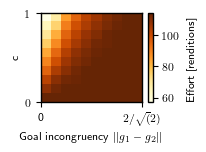

In [12]:
plt.figure()
extent = np.min(dd), np.max(dd), np.min(cc), np.max(cc)
cmap=plt.colormaps['YlOrBr']
cmap.set_bad(color='lightgrey')
ax=plt.imshow(out.T, extent=extent, aspect='auto', origin='lower', cmap=cmap)
cbar = plt.colorbar()
cbar.set_label(labels['E'])
#cbar.set_ticks([])
plt.xlabel(labels['dg2'])
plt.ylabel(labels['c'])
plt.xticks([0, 2/np.sqrt(2)])
plt.gca().set_xticklabels([0, r'$2/\sqrt(2)$'])
plt.yticks([0, 1])
plt.tight_layout()
plt.savefig('figs/fig5b_effort_statespace')

##### Hierarchical learning

We now simulate 9 agents with distinc goals.

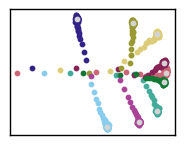

In [13]:
N=9
x0 = np.zeros((N,2))
gk = np.array([[5, 0], [4-2, 1], [4-1, -1],
               [4.707, 0.707], [4.707, -0.707], 
               [4.924, 0.383-0.2], [4.924, -0.383+0.2],
               [4.383-0.5, 0.924], [4.383-0.3, -0.924]])
a = 0.02*10
c = 0.05*10
n = 100
d50 = 100
wn = 0.015
tsim = 1000
tswitch = 1
tpre = 200
ttot = tsim + tpre

seq = np.zeros(ttot, dtype=int)
g = np.tile([[gk[0, 0]], [gk[0, 1]]], ttot).T
for ni in range(N-1):
    seq[ni+1::N] = ni + 1
    g[ni+1::N] = gk[ni + 1]
g[:tpre+tswitch] = x0[0]

C = c*(np.ones((N, N)) - np.identity(N))
X, _ = simulate_optimal(seq, x0, g, a, C, n, d50, wn, rng, tpre)
X = X[tpre:]

a=list(tc.tol_cset('muted'))
a[2],a[3],a[4],a[6]=a[4],a[2],a[6],a[3]
plt.rc('axes', prop_cycle=plt.cycler('color', a))
plt.figure()
for ni in range(N):
    plt.scatter(X[ni::N, ni, 0], X[ni::N, ni, 1], 10)
plt.scatter(gk[:, 0], gk[:, 1], color=colors['g'], s=10)
plt.yticks([])
plt.xticks([])
plt.savefig('figs/fig5c_hierarchical') 

#### Volatile goals


In [14]:
def simulate_volatile(seq, x0, gk, distracted_rendition, a, C, n, d50, wn, rng, tpre, split):
    
    ttot = len(seq)-1
    xt = deepcopy(x0)
    N = x0.shape[0]

    if len(x0.shape)<2: # 1D motor space
        X = np.empty((ttot+1, N))
        G = np.empty((ttot+1))
    else: # multi-dimensional motor space
        X = np.empty((ttot+1, N, x0.shape[1]))
        G = np.empty((ttot+1, x0.shape[1]))
    first_split = np.nan
    X[0,:]= x0
    for t in range(1,ttot+1):
        i = int(seq[t])
        g = np.array([gk[i,0]+xt[i,0], gk[i,1]]) 
        if not distracted_rendition == t:
            X[t, i] = xt[i] + a*(g-xt[i]) + wn*rng.standard_normal(size=xt[i].shape)
            G[t] = g
        else:
            X[t, i] = xt[i] + a*np.array([0,-2])
            G[t] = xt[i] + np.array([0,-2])
        for j in range(N):
            if j!=i and np.linalg.norm(X[t, i] - xt[j])>1e-10: # prevent infinitely small numbers
                H = Hill(X[t, i], xt[j], n, d50)
                x_j_new = xt[j] + H*C[j, i]*(X[t, i] - xt[j])
        
                # stay coupled if benefitial
                if t<=tpre+2 or np.linalg.norm(x_j_new-G[t-1])<np.linalg.norm(xt[j]-G[t-1]) or split==-1:
                    X[t,j] = x_j_new + wn*rng.standard_normal()
                else:
                    X[t,j] = xt[j]
                    if split==0:
                        # split for good
                        C[j,i] = 0
                        C[i,j] = 0
                    if np.isnan(first_split).any():
                        first_split = x_j_new
        xt = X[t]
    return X, G, first_split

In [15]:
# 2D model parameters 
x0 = np.array([[0, 0],[0,0]])   # initial condition
gk = np.array([[5, 1],[5,-1]])  # goals after switch
a = 0.5                     # drift-rate towards goals
c = 0.4                     # coupling constant
n = 100                         # Hill coefficient
d50 = 500                      # Hill constant
wn = 0.00                      # white noise parameter
tsim = 14                     # number of renditions of context 1 and 2 
tpre = 0                      # renditions before trial starts (for equilibration)
ttot = tsim + tpre

# sequence of context renditions
seq = np.zeros(ttot+1, dtype=int)
seq[0::2] = 1

# rendition skipping probability
distracted_rendition = 8

# flag whether splitting is allowed
no_split = -1
split_for_good = 0
split_temporarily = 1

# symmetrical coupling
C = np.array([[0, c], [c, 0.]])

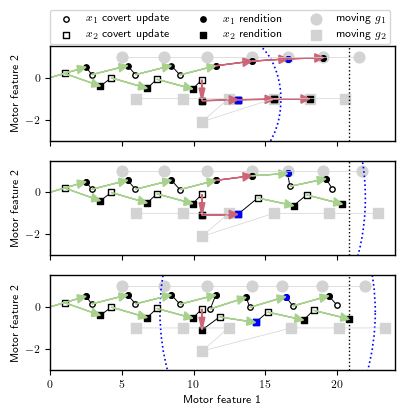

In [16]:
# plotting case 1: split for good
ms=15
X, GX, first_split = simulate_volatile(seq, x0, gk, distracted_rendition, a, C, n, d50, wn, rng, tpre, split_for_good)
f, (a0, a1, a2) = plt.subplots(3, 1, height_ratios=[1, 1,1], figsize=(0.6*w, 0.6*w), sharex=True)
circ1 = pat.Arc(X[11,1,:], 6, 6, theta1=-50, theta2=70, facecolor='blue', edgecolor='blue', ls=':', lw=1.2)
a0.add_artist(circ1)
a0.plot(X[2::1,1,0], X[2::1,1,1], color=colors['H'],zorder=0, lw=0.7)
a0.plot(np.hstack((np.zeros(1),X[1::1,0,0])), np.hstack((np.zeros(1),X[1::1,0,1])), color=colors['H'],zorder=0, lw=0.7)
a0.plot(GX[1::2,0], GX[1::2,1], color=colors['g'],zorder=80,lw=0.5)
a0.plot(GX[2::2,0], GX[2::2,1], color=colors['g'],zorder=80,lw=0.5)
a0.scatter(X[2::2,0,0], X[2::2,0,1], color='white',edgecolors=colors['H'], label='$x_1$ covert update',s=ms)
a0.scatter(X[1::2,1,0], X[1::2,1,1], color='white',marker='s',edgecolors=colors['H'], label='$x_2$ covert update',s=ms)
a0.scatter(X[1::2,0,0], X[1::2,0,1], color=colors['H'], label='$x_1$ rendition',s=ms)
a0.scatter(X[11,0,0], X[11,0,1], color='blue',s=ms)
a0.scatter(X[2::2,1,0], X[2::2,1,1], color=colors['H'],marker='s', label='$x_2$ rendition',s=ms)
a0.scatter(X[10,1,0], X[10,1,1], color='blue',marker='s',s=ms)
for i in range(7):
    if i>=4:
        a0.arrow(X[i*2,0,0], X[i*2,0,1], X[1+i*2,0,0]-X[i*2,0,0], X[1+i*2,0,1]-X[i*2,0,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['ego'])
    else:
        a0.arrow(X[i*2,0,0], X[i*2,0,1], X[1+i*2,0,0]-X[i*2,0,0], X[1+i*2,0,1]-X[i*2,0,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['coop'])
    if i >=3:
        a0.arrow(X[i*2+1,1,0], X[i*2+1,1,1], X[i*2+2,1,0]-X[i*2+1,1,0], X[2+i*2,1,1]-X[i*2+1,1,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['ego'])
    else:
        a0.arrow(X[i*2+1,1,0], X[i*2+1,1,1], X[i*2+2,1,0]-X[i*2+1,1,0], X[2+i*2,1,1]-X[i*2+1,1,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['coop'])
a0.scatter(GX[1::2,0], GX[1::2,1], color=colors['g'],s=ms*4,label='moving $g_1$',zorder=0)
a0.scatter(GX[2::2,0], GX[2::2,1],marker='s', color=colors['g'],s=ms*4, label='moving $g_2$',zorder=0)
a0.legend(ncol=3, bbox_to_anchor=(0, 1.02, 0.2, 0.2), loc="lower left", borderaxespad=0 )
a0.set_xlim([0,24])
a0.set_ylabel(labels['f2'])
a0.set_ylim([-3,1.5])

# case 2: split temporarily
C = np.array([[0, c], [c, 0.]])
X, GX, first_split = simulate_volatile(seq, x0, gk, distracted_rendition, a, C, n, d50, wn, rng, tpre, split_temporarily)
# plotting
circ1 = pat.Arc(X[11,1,:], 15, 15, theta1=-50, theta2=70, facecolor='blue', edgecolor='blue', ls=':', lw=1.2)
a1.add_artist(circ1)
a1.plot(X[2::1,1,0], X[2::1,1,1], color=colors['H'],zorder=0, lw=0.7)
a1.plot(np.hstack((np.zeros(1),X[1::1,0,0])), np.hstack((np.zeros(1),X[1::1,0,1])), color=colors['H'],zorder=0, lw=0.7)
a1.plot(GX[1::2,0], GX[1::2,1], color=colors['g'],zorder=80,lw=0.5)
a1.plot(GX[2::2,0], GX[2::2,1], color=colors['g'],zorder=80,lw=0.5)
a1.scatter(X[2::2,0,0], X[2::2,0,1], color='white',edgecolors=colors['H'], label='$x_1$ covert update',s=ms)
a1.scatter(X[1::2,1,0], X[1::2,1,1], color='white',marker='s',edgecolors=colors['H'], label='$x_2$ covert update',s=ms)
a1.scatter(X[1::2,0,0], X[1::2,0,1], color=colors['H'], label='$x_1$ rendition',s=ms)
a1.scatter(X[1::2,0,0], X[1::2,0,1], color=colors['H'], label='$x_1$ rendition',s=ms)
a1.scatter(X[11,0,0], X[11,0,1], color='blue',s=ms)
a1.scatter(X[2::2,1,0], X[2::2,1,1], color=colors['H'],marker='s', label='$x_2$ rendition',s=ms)
a1.scatter(X[10,1,0], X[10,1,1], color='blue',marker='s',s=ms)
for i in range(7):
    if i>=4 and i<5:
        a1.arrow(X[i*2,0,0], X[i*2,0,1], X[1+i*2,0,0]-X[i*2,0,0], X[1+i*2,0,1]-X[i*2,0,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['ego'])
    else:
        a1.arrow(X[i*2,0,0], X[i*2,0,1], X[1+i*2,0,0]-X[i*2,0,0], X[1+i*2,0,1]-X[i*2,0,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['coop'])
    if i >=3 and i<5:
        a1.arrow(X[i*2+1,1,0], X[i*2+1,1,1], X[i*2+2,1,0]-X[i*2+1,1,0], X[2+i*2,1,1]-X[i*2+1,1,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['ego'])
    else:
        a1.arrow(X[i*2+1,1,0], X[i*2+1,1,1], X[i*2+2,1,0]-X[i*2+1,1,0], X[2+i*2,1,1]-X[i*2+1,1,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['coop'])
a1.set_xlim([0,24])
a1.set_ylabel(labels['f2'])
a1.scatter(GX[1::2,0], GX[1::2,1], color=colors['g'],s=ms*4,zorder=0)
a1.scatter(GX[2::2,0], GX[2::2,1],marker='s', color=colors['g'],s=ms*4,zorder=0)
a1.set_ylim([-3,1.5])

# case 3: forgiveness
C = np.array([[0, c], [c, 0.]])
X, GX, first_split = simulate_volatile(seq, x0, gk, distracted_rendition, a, C, n, d50, wn, rng, tpre, no_split)
# plotting
circ1 = pat.Arc(X[11,1,:], 15, 15, theta1=0, theta2=360, facecolor='blue', edgecolor='blue', ls=':', lw=1.2)
a2.add_artist(circ1)
a2.plot(X[2::1,1,0], X[2::1,1,1], color=colors['H'],zorder=0, lw=0.7)
a2.plot(np.hstack((np.zeros(1),X[1::1,0,0])), np.hstack((np.zeros(1),X[1::1,0,1])), color=colors['H'],zorder=0, lw=0.7)
a2.plot(GX[1::2,0], GX[1::2,1], color=colors['g'],zorder=80,lw=0.5)
a2.plot(GX[2::2,0], GX[2::2,1], color=colors['g'],zorder=80,lw=0.5)
a2.scatter(X[2::2,0,0], X[2::2,0,1], color='white',edgecolors=colors['H'], label='$x_1$ covert update',s=ms)
a2.scatter(X[1::2,1,0], X[1::2,1,1], color='white',marker='s',edgecolors=colors['H'], label='$x_2$ covert update',s=ms)
a2.scatter(X[1::2,0,0], X[1::2,0,1], color=colors['H'], label='$x_1$ rendition',s=ms)
a2.scatter(X[1::2,0,0], X[1::2,0,1], color=colors['H'], label='$x_1$ rendition',s=ms)
a2.scatter(X[11,0,0], X[11,0,1], color='blue',s=ms)
a2.scatter(X[2::2,1,0], X[2::2,1,1], color=colors['H'],marker='s', label='$x_2$ rendition',s=ms)
a2.scatter(X[10,1,0], X[10,1,1], color='blue',marker='s',s=ms)
for i in range(7):
    a2.arrow(X[i*2,0,0], X[i*2,0,1], X[1+i*2,0,0]-X[i*2,0,0], X[1+i*2,0,1]-X[i*2,0,1],
              shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['coop'])
    if i ==3:
        a2.arrow(X[i*2+1,1,0], X[i*2+1,1,1], X[i*2+2,1,0]-X[i*2+1,1,0], X[2+i*2,1,1]-X[i*2+1,1,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['ego'])
    else:
        a2.arrow(X[i*2+1,1,0], X[i*2+1,1,1], X[i*2+2,1,0]-X[i*2+1,1,0], X[2+i*2,1,1]-X[i*2+1,1,1],
                  shape='full', lw=1, length_includes_head=True, head_width=0.4, color=colors['coop'])
a2.set_xlim([0,24])
a2.set_xlabel(labels['f1'])
a2.set_ylabel(labels['f2'])
a0.vlines(X[14,1,0], -3, 1.5, color='black', lw=1, ls=':')
a1.vlines(X[14,1,0], -3, 1.5, color='black', lw=1, ls=':')
a2.vlines(X[14,1,0], -3, 1.5, color='black', lw=1, ls=':')
a2.scatter(GX[1::2,0], GX[1::2,1], color=colors['g'],s=ms*4,zorder=0)
a2.scatter(GX[2::2,0], GX[2::2,1],marker='s', color=colors['g'],s=ms*4,zorder=0)
a2.set_ylim([-3,1.5])
f.tight_layout()
f.savefig('figs/fig6ab_forgiveness')

#### Combining estimates of uncertain goals
If the individual goals are sampled from a Gaussian distribution (e.g. due to sensory noise), what accuracy will the collective achieve?

In [17]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1./(2.*np.pi*sx*sy)*np.exp(-((x - mx)**2./(2.*sx**2.) + (y - my)**2./(2.*sy**2.)))

# collective learning
N = 20
d50 = 100
wn = 0.00   
n = 100            
c = 0.05
a = 0.2        
tsim = 5000
tswitch = 1
tpre = 200
ttot = tsim + tpre

gk = rng.standard_normal((20,2))
x0 = 2*np.ones((N,2))
seq = np.zeros(ttot, dtype=int)
g = np.tile([[gk[0,0]],[gk[0,1]]],ttot).T
for ni in range(N-1):
    seq[ni+1::N] = ni+1
    g[ni+1::N] = gk[ni+1]

g[:tpre+tswitch] = x0[0]
C = c*(np.ones((N, N)) - np.identity(N))
X = simulate(seq, x0, g, a, C, n, d50, wn, rng)
X = X[tpre:]
xx = np.empty((10*N,2))
for t in range(10*N):
    i= seq[-t-1]
    xx[t] = X[-t-1,i] 

# goal PDF and vox populi
s = 3 # grid length
x = np.linspace(-s, s, 51)
y = np.linspace(-s, s, 51)
step = 2*s/50
gk = (gk + s)/step # center goals on grid
xx = (xx + s)/step # center steady state agents on grid
vox = np.mean(gk,0) # vox populi
x, y = np.meshgrid(x, y) 
z = gaus2d(x, y)

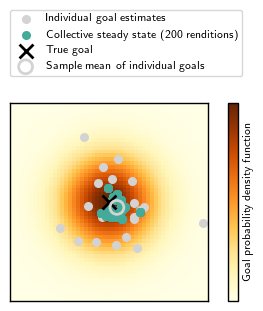

In [18]:
plt.figure(figsize=(0.6*w, 0.495*w))
cmap = plt.colormaps['YlOrBr']
plt.imshow(z, cmap=cmap)
cbar = plt.colorbar(shrink=1)
cbar.set_label('Goal probability density function')
cbar.set_ticks([])
plt.yticks([])
plt.xticks([])
plt.scatter(gk[:,0], gk[:,1], color=colors['g'], s=30, label='Individual goal estimates')
plt.scatter(xx[:,0], xx[:,1], color=colors['x2'], s=30, label='Collective steady state (200 renditions)')
plt.scatter(s/step,s/step,color='black', marker='x', s=100, label='True goal', lw=2)
plt.scatter(vox[0], vox[1], facecolors='none',edgecolors=colors['g'], s=100, label='Sample mean of individual goals',lw=2)
plt.legend(bbox_to_anchor=(-0.03,1.5), loc='upper left')
plt.tight_layout()
plt.savefig('figs/fig7a_PDF') 

In [19]:
replicates = 200
ncc = 9  # number of screens for coupling constant c 
nnn = 9    # number of screens for group size N
out_coll = np.empty((nnn, ncc))   # Actual mean error of agents divided by standard error 
out_strain = np.empty((nnn, ncc)) # SD of agents ("strain")
cc = np.logspace(-3, -1, ncc)
nn = np.linspace(2,10,nnn,dtype=int)
SE = np.empty(nnn)
seq = np.zeros(ttot, dtype=int)

for k, N in enumerate(nn):
    SE[k] = 1/np.sqrt(N)
    x0 = 2*np.ones((N,2))
    for j,c in enumerate(cc):
        C = c*(np.ones((N, N)) - np.identity(N))
        d_coll = np.empty(replicates)
        sd_coll = np.empty(replicates)
        for r in range(replicates):
            gk = rng.standard_normal((N, 2))
            g = np.tile([[gk[0,0]], [gk[0,1]]], ttot).T
            for ni in range(N - 1):
                seq[ni+1::N] = ni + 1
                g[ni+1::N] = gk[ni+1]
            g[:tpre+tswitch] = x0[0]
            X = simulate(seq, x0, g, a, C, n, d50, wn, rng)
            X = X[tpre:]
            xx = np.empty((10*N,2))
            for t in range(10*N):
                i= seq[-t-1]
                xx[t] = np.linalg.norm(X[-t-1,i])
            d_coll[r] = np.mean(xx)
            sd_coll[r] = np.std(xx)
        out_coll[k,j] = np.mean(d_coll)/SE[k]
        out_strain[k,j] = np.mean(sd_coll)

<Figure size 269.291x162.992 with 0 Axes>

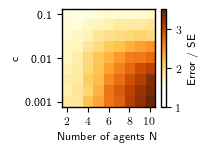

In [20]:
plt.figure(figsize=(0.38*w, 0.23*w))
fig, ax = plt.subplots(1,1)
extent = np.min(nn)-0.5, np.max(nn)+0.5,np.min(nn)-0.5, np.max(nn)+0.5
cmap = plt.colormaps['YlOrBr']
cmap.set_bad(color='lightgrey')
img=ax.imshow(out_coll.T, extent=extent, aspect='auto', origin='lower', cmap=cmap)
cbar = fig.colorbar(img)
cbar.set_label('Error / SE')
cbar.set_ticks([1,2,3])
ax.set_xlabel('Number of agents N')
ax.set_ylabel(labels['c'])
ax.set_yticks([2,6,10])
ax.set_yticklabels([0.001,0.01,0.1])
ax.set_xticks(np.arange(2,11,2))
plt.tight_layout()
plt.savefig('figs/fig7b_robustness_statespace')

<Figure size 269.291x162.992 with 0 Axes>

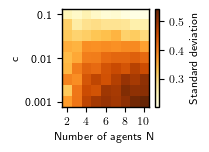

In [21]:
plt.figure(figsize=(0.38*w, 0.23*w))
fig, ax = plt.subplots(1,1)
extent = np.min(nn)-0.5, np.max(nn)+0.5,np.min(nn)-0.5, np.max(nn)+0.5
cmap = plt.colormaps['YlOrBr']
cmap.set_bad(color='lightgrey')
img=ax.imshow(out_strain.T, extent=extent, aspect='auto', origin='lower', cmap=cmap)
cbar = fig.colorbar(img)
cbar.set_label('Standard deviation')
ax.set_xlabel('Number of agents N')
ax.set_ylabel(labels['c'])
ax.set_yticks([2,6,10])
ax.set_yticklabels([0.001,0.01,0.1])
ax.set_xticks(np.arange(2,11,2))
plt.tight_layout()
plt.savefig('figs/fig7c_strain_statespace')